***

### **Importante** 


- **Realice varios comentarios haciendo uso de una etiqueta html para darle color al comentario. Sin embargo, al subir mis notebooks a GITHUB las secciones donde realice los comentarios a color aparecen en blanco.**  

- **El "Enable Scrolling for Outputs" no se respeta al subir este contenido a GITHUB, por lo tanto, la impresión de los datos puede ser larga.**  

**Lo anterior no afecta en absoluto el contenido principal y el funcionamiento del documento, por lo que, si lo deseas, lo puedes ejecutar sin ningún problema en tu ordenador.**

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Cargamos nuestros datos:

In [33]:
from mnist import MNIST

In [34]:
Datos_MNIST = MNIST("MNIST_dataset") # Cargamos la totalidad de datos de MNIST.

In [35]:
imagenes_entrenamiento, etiquetas_entrenamiento = Datos_MNIST.load_training() # Cargando datos de entrenamiento.
imagenes_testeo, etiquetas_testeo = Datos_MNIST.load_testing() # Cargando datos para probar nuestra red una vez se halla entrenado.

Damos formato a nuestros datos MNIST:

In [36]:
imagenes_entrenamiento, etiquetas_entrenamiento = np.asarray(imagenes_entrenamiento), np.asarray(etiquetas_entrenamiento)
imagenes_testeo, etiquetas_testeo = np.asarray(imagenes_testeo), np.asarray(etiquetas_testeo)

In [37]:
imagenes_entrenamiento = (imagenes_entrenamiento/imagenes_entrenamiento.max()).astype("float64")

In [38]:
imagenes_testeo = (imagenes_testeo/imagenes_testeo.max()).astype("float64")

In [39]:
def one_hot_encode (etiquetas):
    """Esta función nos arroja un vector one_hot para cada etiqueta."""
    
    cantidad_clases = len(set(etiquetas))
    vector_OneHot = np.zeros(shape=(etiquetas.shape[0], cantidad_clases), dtype="float64")
    
    for i in range(vector_OneHot.shape[0]):
        vector_OneHot[i,etiquetas[i]] = 1
        
    return vector_OneHot

In [40]:
etiquetas_entrenamiento_ONE_HOT = one_hot_encode(etiquetas_entrenamiento)
etiquetas_testeo_ONE_HOT = one_hot_encode(etiquetas_testeo)

Tomaremos 1,000 muestras del conjunto de entrenamiento para entrenar de maner rápida a nuestra red:

In [41]:
muestras_entrenamiento_1500 = imagenes_entrenamiento[:1500]
etiquetas_entrenamiento_1500 = etiquetas_entrenamiento_ONE_HOT[:1500]

In [42]:
print(muestras_entrenamiento_1500.shape)
print(etiquetas_entrenamiento_1500.shape)

(1500, 784)
(1500, 10)


Tomaremos 180 muestras para el conjunto de validación:

In [43]:
validacion_img_aleatorias = imagenes_entrenamiento[1500:]
validacion_etiquetas_aleatorias = one_hot_encode(etiquetas_entrenamiento[1500:])

print(validacion_img_aleatorias.shape)
print(validacion_etiquetas_aleatorias.shape)

(58500, 784)
(58500, 10)


In [44]:
validacion_etiquetas_aleatorias[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

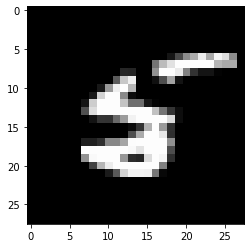

In [45]:
plt.imshow(validacion_img_aleatorias[9].reshape(28,28), cmap="gray")

Recordemos que (para nuestro caso), las representaciones digitales de los números ya se encuentran en 1D. Las dimensiones para nuestras muestras de entrenamiento son: (lote, numeros).

*Comienza nuestro algoritmo de aprendizaje:*

In [46]:
import random

def generador (x):
    """Esta función es un generador y nos ayuda a ahorrar memoria, dado que va entregando cada número de la secuencia conforme este es
    solicitado, a diferencia de una lista convecional que genera todos los números, los carga en memoria y luego itera sobre estos."""
    
    for i in range(x):
        
        yield i

#################################
relu = lambda sp: (sp > 0) * sp
derivada_relu = lambda sp: sp > 0
#################################

def algoritmo_aprendizaje (entradas, salidas_deseadas, pesos, alfa, epocas, datos_validacion=False):
    """Esta función ejecuta el algoritmo de aprendizaje de nuestra red neuronal."""
    
    pesos_capas = [pesos_x_capa.copy() for pesos_x_capa in pesos]
    
    error_deseado = float(input("\nHola ¿Cuál es el error que mínimo que deseas para la red neuronal?: "))
    
    regularizacion_ = int(input("¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):\n"))
    
    assert regularizacion_ in [0,1,2,3,4], "INGRESA UNA OPCIÓN VÁLIDA."
    
    if regularizacion_ == 1 or regularizacion_ == 2:
        
        lmda = float(input("Inserta el porcentaje deseado para esta regularización: lambda[0,infinito)\n"))
        
    if regularizacion_ == 3:
        
        porcentaje_dpt = float(input("¿Qué porcentaje de DROPOUT deseas? 0 < dp < 1\n"))
    
    if regularizacion_ == 4:
        
        tamaño_lote = int(input("Ingresa la cantidad de muestras por lote: "))
        assert len(entradas) % tamaño_lote == 0, "¡Ingresa una cantidad que divida el conjunto de datos en lotes iguales!"
        
    
    error_red = list()
    error_validacion = list()
    
    for epoca in generador(epocas):
        
        error_x_entrada, aciertos = 0.0, 0.0
        
        for entrada, salida_deseada in zip(entradas, salidas_deseadas): # entrada = capa_0.
            
            if regularizacion_ == 1: # Modelo con regularización L2.
                
                # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:
                
                capa_1 = relu(entrada@pesos_capas[0]).reshape(1,-1) # Forma resultante: Vector.
                capa_2 = capa_1@pesos_capas[1] # Forma resultante: Vector. Para este caso, este vector representa las predicciones.
                
                # Error con penalización agregada L2:
                
                error_x_entrada += np.sum((capa_2 - salida_deseada)**2) \
                + lmda*(np.sum(pesos_capas[0]**2) + np.sum(pesos[1]**2)) # Penalización L2.
                
                # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:
            
                # Deltas y pesos delta de neuronas en la capa 2:
                deltas_neuronas_salida = 2*(capa_2 - salida_deseada)*1
                pesos_delta_ncs =  capa_1.T.dot(deltas_neuronas_salida) + lmda*(2*pesos_capas[1])

                # Deltas y pesos delta de nueronas en la capa 1:
                deltas_neuronas_c1 = derivada_relu(capa_1)*(pesos_capas[1]@deltas_neuronas_salida.T).T
                pesos_delta_nc1 = entrada.reshape(1,-1).T.dot(deltas_neuronas_c1) + lmda*(2*pesos_capas[0])
                
                # Actualizamos los parámetros:
            
                # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
                pesos_capas[1] = pesos_capas[1] * (1 - alfa*lmda) - (alfa * pesos_delta_ncs)

                # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
                pesos_capas[0] = pesos_capas[0] * (1 - alfa*lmda) - (alfa * pesos_delta_nc1)
                
            elif regularizacion_ == 2: # Modelo con regularización L1.
                
                # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:
                
                capa_1 = relu(entrada@pesos_capas[0]).reshape(1,-1) # Forma resultante: Vector.
                capa_2 = capa_1@pesos_capas[1] # Forma resultante: Vector. Para este caso, este vector representa las predicciones.
                
                # Error con penalización agregada L1:
                error_x_entrada += np.sum((capa_2 - salida_deseada)**2) \
                + lmda*(np.sum(abs(pesos_capas[0])) + np.sum(abs(pesos_capas[1]))) # Penalización L1.
                
                # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:
            
                # Deltas y pesos delta de neuronas en la capa 2:
                deltas_neuronas_salida = 2*(capa_2 - salida_deseada)*1
                dpw_1_2 = np.asarray([-lmda if peso < 0 else lmda for pesos_fila in pesos_capas[1] 
                                      for peso in pesos_fila]).reshape(pesos_capas[1].shape)
                pesos_delta_ncs =  capa_1.T.dot(deltas_neuronas_salida) + dpw_1_2

                # Deltas y pesos delta de nueronas en la capa 1:
                deltas_neuronas_c1 = derivada_relu(capa_1)*(pesos_capas[1]@deltas_neuronas_salida.T).T
                dpw_0_1 = np.asarray([-lmda if peso < 0 else lmda for pesos_fila in pesos_capas[0] 
                                      for peso in pesos_fila]).reshape(pesos_capas[0].shape)
                pesos_delta_nc1 = entrada.reshape(1,-1).T.dot(deltas_neuronas_c1) + dpw_0_1
                
                # Actualizamos los parámetros:
            
                # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
                pesos_capas[1] = pesos_capas[1] - (alfa*lmda*dpw_1_2) - (alfa * pesos_delta_ncs) # dpw = derivada parcial de w.

                # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
                pesos_capas[0] = pesos_capas[0] - (alfa*lmda*dpw_0_1) - (alfa * pesos_delta_nc1) # dpw = derivada parcial de w.
                
            elif regularizacion_ == 3: # Regularización Dropout:
                
                # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:
            
                capa_1 = relu(entrada@pesos_capas[0]).reshape(1,-1) # Forma resultante: Vector.
                
                assert capa_1.shape[1]%2 == 0, "LA LONGITUD DEL VECTOR DE LA CAPA 1 DEBE SER 'PAR' PARA PODER APLICAR EL PORCENTAJE \
                EXACTO DE 'DROPOUT' DESEADO."
                
                # Vector Dropout:
                unos = (1 - porcentaje_dpt) * capa_1.shape[1]
                ceros = porcentaje_dpt * capa_1.shape[1]
                
                ceros_y_unos = list(np.zeros(shape=(int(ceros)))) + list(np.ones(shape=(int(unos))))
                
                random.shuffle(ceros_y_unos) # Revolvemos los 1's y 0's para exista aleatoriedad.
                
                # Multiplicamos el vector de  la capa 1 por el vector Dropout y compensamos el vector resultante dividiendo entre 
                # el procentaje de Dropout:
                capa_1 *= np.asarray(ceros_y_unos).reshape(1,-1)
                capa_1 /= porcentaje_dpt
                
                # Continua la propagación hacia adelante:
                capa_2 = capa_1@pesos_capas[1] # Forma resultante: Vector. Para este caso, este vector representa las predicciones.
            
                error_x_entrada += np.sum((capa_2 - salida_deseada)**2)

                # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:

                # Deltas y pesos delta de neuronas en la capa 2:
                deltas_neuronas_salida = 2*(capa_2 - salida_deseada)*1
                pesos_delta_ncs =  capa_1.T.dot(deltas_neuronas_salida)

                # Deltas y pesos delta de nueronas en la capa 1:
                deltas_neuronas_c1 = derivada_relu(capa_1)*(pesos_capas[1]@deltas_neuronas_salida.T).T
                deltas_neuronas_c1 *= np.asarray(ceros_y_unos).reshape(1,-1) # Multiplicamos las deltas de la capa 1 por el vector de dropout.
                pesos_delta_nc1 = entrada.reshape(1,-1).T.dot(deltas_neuronas_c1)

                # Actualizamos los parámetros:

                # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
                pesos_capas[1] -= alfa * pesos_delta_ncs

                # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
                pesos_capas[0] -= alfa * pesos_delta_nc1
                
            elif regularizacion_ == 4: # Descenso del gradiente estocástico por mini-lotes.
                
                for i in range(int(len(entradas)/tamaño_lote)):
                
                    # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:

                    capa_1 = relu(entradas[(i*tamaño_lote):((i+1)*tamaño_lote),:]@pesos_capas[0]) # Forma resultante: Matriz.
                    capa_2 = capa_1@pesos_capas[1] # Forma resultante: Matriz. Para este caso, esta matriz representa las predicciones.

                    error_x_entrada += np.sum((capa_2 - salidas_deseadas[(i*tamaño_lote):((i+1)*tamaño_lote),:])**2)
                    
                    for k in range(tamaño_lote): # Calculamos la cantidad de aciertos por época sobre los datos de entrenamiento.
                        
                        aciertos += int(np.argmax(capa_2[k:k+1]) == np.argmax(salidas_deseadas[i*tamaño_lote+k:i*tamaño_lote+k+1]))
                        
                    # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:

                    deltas_neuronas_salida = 2*(capa_2 - salidas_deseadas[(i*tamaño_lote):((i+1)*tamaño_lote),:])*1
                    pesos_delta_nc2 = capa_1.T.dot(deltas_neuronas_salida) / tamaño_lote

                    deltas_neuronas_c1 = deltas_neuronas_salida.dot(pesos_capas[1].T) * derivada_relu(capa_1)
                    pesos_delta_nc1 = entradas[(i*tamaño_lote):((i+1)*tamaño_lote),:].T.dot(deltas_neuronas_c1) / tamaño_lote

                    # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
                    pesos_capas[1] -= alfa * pesos_delta_nc2

                    # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
                    pesos_capas[0] -= alfa * pesos_delta_nc1
                        
   
                break
            
            else: # Modelo sin ningun tipo de regularización.
                
                # Propagación hacia adelante. Nuestra red realiza la predicción (o inferencia), por cada muestra:
                
                capa_1 = relu(entrada@pesos_capas[0]).reshape(1,-1) # Forma resultante: Vector.
                capa_2 = capa_1@pesos_capas[1] # Forma resultante: Vector. Para este caso, este vector representa las predicciones.

                error_x_entrada += np.sum((capa_2 - salida_deseada)**2)
                
                # Backpropagation. Calculamos los delta de cada neurona de la red y sus respectivos pesos delta:
            
                # Deltas y pesos delta de neuronas en la capa 2:
                deltas_neuronas_salida = 2*(capa_2 - salida_deseada)*1
                pesos_delta_ncs =  capa_1.T.dot(deltas_neuronas_salida)

                # Deltas y pesos delta de nueronas en la capa 1:
                deltas_neuronas_c1 = derivada_relu(capa_1)*(pesos_capas[1]@deltas_neuronas_salida.T).T
                pesos_delta_nc1 = entrada.reshape(1,-1).T.dot(deltas_neuronas_c1)
                
                # Actualizamos los parámetros:
            
                # Actualizamos los pesos que se encuentran entre las capas 1 y 2:
                pesos_capas[1] -= alfa * pesos_delta_ncs

                # Actualizamos los pesos que se encuentran entre las capas 0 y 1:
                pesos_capas[0] -= alfa * pesos_delta_nc1
            
            aciertos += int(np.argmax(capa_2) == np.argmax(salida_deseada))
            
        if datos_validacion:
            
            # Validamos el aprendizaje de nuestra en cada época:
            error_x_muestra_validacion = 0
            aciertos_validacion = 0

            for numero, etiqueta in zip(datos_validacion[0], datos_validacion[1]): # datos_validacion contienen a los números y etiquetas.

                c1 = relu(numero@pesos_capas[0]).reshape(1,-1)
                c2 = c1@pesos_capas[1]

                error_x_muestra_validacion += np.sum((c2 - etiqueta)**2)
                aciertos_validacion += int(np.argmax(c2) == np.argmax(etiqueta))

            error_total_validacion = (error_x_muestra_validacion/len(datos_validacion[1]))*100 # ECM dado en porcentaje en D. Validación.
            error_validacion.append(error_total_validacion)
            
        # Datos generales de la red:
        error_x_epoca = (error_x_entrada/len(entradas))*100 # ECM dado en porcentaje en D. Entrenamiento.
        error_red.append(error_x_epoca)
        
        print(f"\nÉpoca: {epoca+1}")
        print(f"Error Total de la Red sobre los Datos de Entrenamiento: {np.around(error_x_epoca,10)}%")
        print(f"Aciertos sobre Datos de Entrenamiento: {aciertos}")
        
        if datos_validacion:
            
            print(f"Error de Validación: {np.around(error_total_validacion,10)}%")
            print(f"Aciertos sobre los Datos de Validación: {aciertos_validacion}\n")
        
        if error_x_epoca <= error_deseado:
            print("\nEl error de la red neuronal es menor o igual al error deseado.\n")
            break
        
    return pesos_capas, error_red, error_validacion

Creamos una función que nos permita realizar predicciones:

In [47]:
def predicciones (pesos,entradas):
    
    vector_prediccion = list()
    
    for entrada in entradas:
        neuronas_capa_1 = relu(entrada.dot(pesos[0])) # Forma resultante: Vector.
        neuronas_de_salida = neuronas_capa_1@pesos[1] # Forma resultante: Vector.
        vector_prediccion.append(np.argmax(neuronas_de_salida))
            
    return np.asarray(vector_prediccion)

### <font color="red">Fuentes para obtener las fórmulas de ambas regularizaciones (L1 y L2): Neural Networks and Deep Learning, pág 182 y 184</font>  

### <font color="darkorange">Porcentaje LAMBDA = 0.001 (Deep learning with python, pág 108). Sin embargo, a mi me funciona mejor L2 = 0.004 y L1 = 0.001.</font>

Definimos los datos a ingresar a la red:

In [29]:
np.random.seed(10)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 50, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

### Con Regularización L2 (lambda = 0.004):

Entrenamos nuestra red:

In [92]:
pesos_entrenados_L2, error_red_L2, error_validacion_L2 = algoritmo_aprendizaje(muestras_entrenamiento_1500, etiquetas_entrenamiento_1500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 1
Inserta el porcentaje deseado para esta regularización: lambda[0,infinito)
 0.004



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 99.9781378921%
Aciertos sobre Datos de Entrenamiento: 965.0
Error de Validación: 45.4787818048%
Aciertos sobre los Datos de Validación: 46334


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 70.1446356762%
Aciertos sobre Datos de Entrenamiento: 1263.0
Error de Validación: 35.7932048981%
Aciertos sobre los Datos de Validación: 49173


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 57.1332935801%
Aciertos sobre Datos de Entrenamiento: 1315.0
Error de Validación: 31.3787708015%
Aciertos sobre los Datos de Validación: 50414


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 48.8170315983%
Aciertos sobre Datos de Entrenamiento: 1354.0
Error de Validación: 29.2347218749%
Aciertos sobre los Datos de Validación: 50944


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 42.8209016611%
Aciertos sobre Datos de Entrenamiento: 1375.0
Error de Validación: 27.8194699141

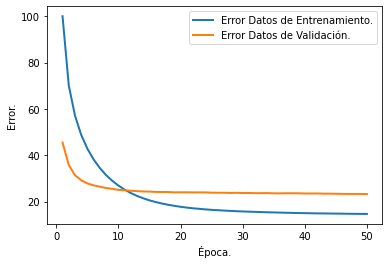

In [93]:
epocas = range(1, len(error_red_L2)+1)
plt.plot(epocas, error_red_L2, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_L2, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [94]:
vp_L2 = predicciones(pesos_entrenados_L2, imagenes_entrenamiento[:1500])
print(vp_L2.shape,'\n')

precision_L2 = ((etiquetas_entrenamiento[:1500] == vp_L2).sum()/len(etiquetas_entrenamiento[:1500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:1500].shape[0]} datos de entrenamiento es del {precision_L2}%")

(1500,) 

La precisión sobre los 1500 datos de entrenamiento es del 98.73333333333333%


In [95]:
vp_L2_T = predicciones(pesos_entrenados_L2, imagenes_testeo[:])
print(vp_L2_T.shape,'\n')

DI_L2_T = (etiquetas_testeo[:] == vp_L2_T).sum() # Datos Inferidos en el cojunto de testeo o prueba.

precision_L2_T = (DI_L2_T/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_L2_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 90.21000000000001%


In [96]:
print(f"La cantidad de datos inferida por este modelo es: {DI_L2_T}")

La cantidad de datos inferida por este modelo es: 9021


### Con Regularización L1 (lambda = 0.001):

In [98]:
pesos_entrenados_L1, error_red_L1, error_validacion_L1 = algoritmo_aprendizaje(muestras_entrenamiento_1500, etiquetas_entrenamiento_1500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 2
Inserta el porcentaje deseado para esta regularización: lambda[0,infinito)
 0.001



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 208.7599240668%
Aciertos sobre Datos de Entrenamiento: 963.0
Error de Validación: 45.0277104951%
Aciertos sobre los Datos de Validación: 46389


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 163.8807926691%
Aciertos sobre Datos de Entrenamiento: 1259.0
Error de Validación: 35.5080296718%
Aciertos sobre los Datos de Validación: 49123


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 137.0092506776%
Aciertos sobre Datos de Entrenamiento: 1308.0
Error de Validación: 31.1540613433%
Aciertos sobre los Datos de Validación: 50365


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 115.8591518379%
Aciertos sobre Datos de Entrenamiento: 1345.0
Error de Validación: 29.0387252817%
Aciertos sobre los Datos de Validación: 50973


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 98.2606268753%
Aciertos sobre Datos de Entrenamiento: 1367.0
Error de Validación: 27.761355

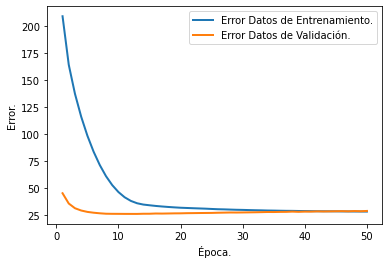

In [99]:
epocas = range(1, len(error_red_L1)+1)
plt.plot(epocas, error_red_L1, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_L1, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [100]:
vp_L1_entrenamiento = predicciones(pesos_entrenados_L1, imagenes_entrenamiento[:1500])
print(vp_L1_entrenamiento.shape,'\n')

precision_L1_entrenamiento = ((etiquetas_entrenamiento[:1500] == vp_L1_entrenamiento).sum()/len(etiquetas_entrenamiento[:1500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:1500].shape[0]} datos de entrenamiento es del {precision_L1_entrenamiento}%")

(1500,) 

La precisión sobre los 1500 datos de entrenamiento es del 95.93333333333334%


In [101]:
vp_L1_T = predicciones(pesos_entrenados_L1, imagenes_testeo[:])
print(vp_L1_T.shape,'\n')

DI_L1_T = (etiquetas_testeo[:] == vp_L1_T).sum() # Datos Inferidos en el cojunto de testeo o prueba.

precision_L1_T = (DI_L1_T/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_L1_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 86.45%


In [102]:
print(f"La cantidad de datos inferida por este modelo es: {DI_L1_T}")

La cantidad de datos inferida por este modelo es: 8645


### Sin Regularización:

In [103]:
pesos_entrenados_SR, error_red_SR, error_validacion_SR = algoritmo_aprendizaje(muestras_entrenamiento_1500, etiquetas_entrenamiento_1500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 0



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 60.679388827%
Aciertos sobre Datos de Entrenamiento: 969.0
Error de Validación: 45.6196968202%
Aciertos sobre los Datos de Validación: 46305


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 36.7270528679%
Aciertos sobre Datos de Entrenamiento: 1258.0
Error de Validación: 36.199507296%
Aciertos sobre los Datos de Validación: 49073


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 28.53216038%
Aciertos sobre Datos de Entrenamiento: 1312.0
Error de Validación: 31.8181272904%
Aciertos sobre los Datos de Validación: 50293


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 24.1279938034%
Aciertos sobre Datos de Entrenamiento: 1361.0
Error de Validación: 29.8675361206%
Aciertos sobre los Datos de Validación: 50841


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 21.4068463937%
Aciertos sobre Datos de Entrenamiento: 1387.0
Error de Validación: 28.5842597475%
Ac

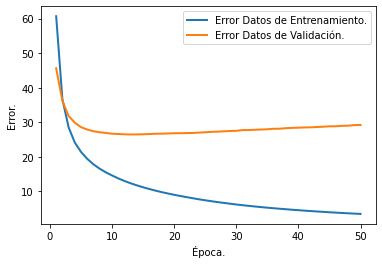

In [104]:
epocas = range(1, len(error_red_SR)+1)
plt.plot(epocas, error_red_SR, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_SR, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [105]:
vp_SR = predicciones(pesos_entrenados_SR, imagenes_entrenamiento[:1500])
print(vp_SR.shape,'\n')

precision_SR_T = ((etiquetas_entrenamiento[:1500] == vp_SR).sum()/len(etiquetas_entrenamiento[:1500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:1500].shape[0]} datos de entrenamiento es del {precision_SR_T}%")

(1500,) 

La precisión sobre los 1500 datos de entrenamiento es del 99.26666666666667%


In [106]:
vp_SR_T = predicciones(pesos_entrenados_SR, imagenes_testeo[:])
print(vp_SR_T.shape,'\n')

DI_SR_T = (etiquetas_testeo[:] == vp_SR_T).sum() # Datos Inferidos en el cojunto de testeo o prueba.

precision_SR_T = (DI_SR_T/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_SR_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 87.3%


In [107]:
print(f"La cantidad de datos inferida por este modelo es: {DI_SR_T}")

La cantidad de datos inferida por este modelo es: 8730


### Con Dropout (al 50% -> 0.5):

In [109]:
pesos_entrenados_DPT, error_red_DPT, error_validacion_DPT = algoritmo_aprendizaje(muestras_entrenamiento_1500, etiquetas_entrenamiento_1500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 3
¿Qué porcentaje de DROPOUT deseas? 0 < dp < 1
 0.5



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 81.18654046%
Aciertos sobre Datos de Entrenamiento: 539.0
Error de Validación: 62.3087859694%
Aciertos sobre los Datos de Validación: 37511


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 62.9208200834%
Aciertos sobre Datos de Entrenamiento: 879.0
Error de Validación: 48.750876678%
Aciertos sobre los Datos de Validación: 45192


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 55.9578641405%
Aciertos sobre Datos de Entrenamiento: 963.0
Error de Validación: 44.3076171914%
Aciertos sobre los Datos de Validación: 46461


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 50.9042546524%
Aciertos sobre Datos de Entrenamiento: 1029.0
Error de Validación: 39.6435940307%
Aciertos sobre los Datos de Validación: 47078


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 48.8669655445%
Aciertos sobre Datos de Entrenamiento: 1050.0
Error de Validación: 37.9797948955%
Aci

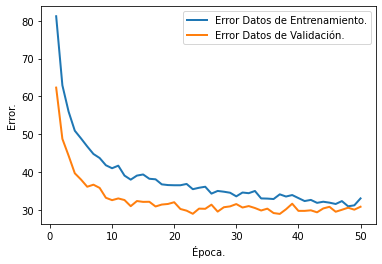

In [110]:
epocas = range(1, len(error_red_DPT)+1)
plt.plot(epocas, error_red_DPT, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_DPT, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [111]:
vp_DPT = predicciones(pesos_entrenados_DPT, imagenes_entrenamiento[:1500])
print(vp_DPT.shape,'\n')

precision_DPT = ((etiquetas_entrenamiento[:1500] == vp_DPT).sum()/len(etiquetas_entrenamiento[:1500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:1500].shape[0]} datos de entrenamiento es del {precision_DPT}%")

(1500,) 

La precisión sobre los 1500 datos de entrenamiento es del 97.39999999999999%


In [112]:
vp_DPT_T = predicciones(pesos_entrenados_DPT, imagenes_testeo[:])
print(vp_DPT_T.shape,'\n')

DI_DPT_T = (etiquetas_testeo[:] == vp_DPT_T).sum() # Datos Inferidos en el cojunto de testeo o prueba.

precision_DPT_T = (DI_DPT_T/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_DPT_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 86.86%


In [113]:
print(f"La cantidad de datos inferida por este modelo es: {DI_DPT_T}")

La cantidad de datos inferida por este modelo es: 8686


***

### Descenso del gradiente por lotes:

In [56]:
np.random.seed(10)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.1, 350, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

pesos_entrenados_Lts, error_red_Lts, error_validacion_Lts = algoritmo_aprendizaje(imagenes_entrenamiento[:50000], etiquetas_entrenamiento_ONE_HOT[:50000], 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [imagenes_entrenamiento[50000:], etiquetas_entrenamiento_ONE_HOT[50000:]])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 4
Ingresa la cantidad de muestras por lote:  50



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 26.821020778%
Aciertos sobre Datos de Entrenamiento: 43860.0
Error de Validación: 18.0368624203%
Aciertos sobre los Datos de Validación: 9323


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 17.487442779%
Aciertos sobre Datos de Entrenamiento: 46606.0
Error de Validación: 15.7712037019%
Aciertos sobre los Datos de Validación: 9452


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 15.5146938316%
Aciertos sobre Datos de Entrenamiento: 47155.0
Error de Validación: 14.6786950813%
Aciertos sobre los Datos de Validación: 9490


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 14.3861363079%
Aciertos sobre Datos de Entrenamiento: 47426.0
Error de Validación: 14.0629221152%
Aciertos sobre los Datos de Validación: 9515


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 13.6823182044%
Aciertos sobre Datos de Entrenamiento: 47618.0
Error de Validación: 13.7018366792

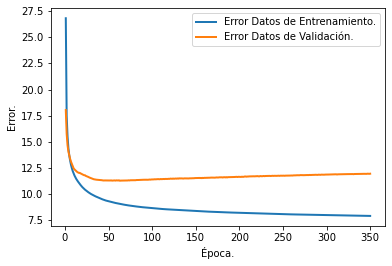

In [57]:
epocas = range(1, len(error_red_Lts)+1)
plt.plot(epocas, error_red_Lts, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_Lts, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [58]:
vp_Lts = predicciones(pesos_entrenados_Lts, imagenes_entrenamiento[:])
print(vp_Lts.shape,'\n')

precision_Lts = ((etiquetas_entrenamiento[:] == vp_Lts).sum()/len(etiquetas_entrenamiento[:]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:].shape[0]} datos de entrenamiento es del {precision_Lts}%")

(60000,) 

La precisión sobre los 60000 datos de entrenamiento es del 97.70666666666666%


In [59]:
vp_Lts_T = predicciones(pesos_entrenados_Lts, imagenes_testeo[:])
print(vp_Lts_T.shape,'\n')

DI_Lts_T = (etiquetas_testeo[:] == vp_Lts_T).sum() # Datos Inferidos en el cojunto de testeo o prueba.

precision_Lts_T = (DI_Lts_T/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_Lts_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 95.8%


In [60]:
print(f"La cantidad de datos inferida por este modelo es: {DI_Lts_T}")

La cantidad de datos inferida por este modelo es: 9580


<font color="darkorange">*No incluí este modelo en las gráficas, ya que a pesar de que el entrenamiento por lotes representa una forma de regularización debido a que se obtiene el gradiente promedio por lote para cada parámetro, este tipo de descenso del gradiente se suele usar en conjunto con los otros métodos de regularización. Además, el valor óptimo que encontre para este modelo fue de "0.1", por lo que, no sería adecuado comparar modelos cuyos hyperparametros varien demasiado.*</font>

***

### Un modelo sin regularización, pero más simple (cuenta con 20 neuronas menos en la 1er capa):

In [114]:
np.random.seed(10)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 50, 20, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

pesos_entrenados_MS, error_red_MS, error_validacion_MS = algoritmo_aprendizaje(muestras_entrenamiento_1500, etiquetas_entrenamiento_1500, 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [validacion_img_aleatorias, validacion_etiquetas_aleatorias])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 0



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 67.2536090998%
Aciertos sobre Datos de Entrenamiento: 859.0
Error de Validación: 51.3201207853%
Aciertos sobre los Datos de Validación: 43002


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 42.154690797%
Aciertos sobre Datos de Entrenamiento: 1190.0
Error de Validación: 39.2651416507%
Aciertos sobre los Datos de Validación: 47331


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 32.0829795704%
Aciertos sobre Datos de Entrenamiento: 1287.0
Error de Validación: 33.6738351389%
Aciertos sobre los Datos de Validación: 49060


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 26.6329961491%
Aciertos sobre Datos de Entrenamiento: 1331.0
Error de Validación: 30.6842166361%
Aciertos sobre los Datos de Validación: 49957


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 23.2280861053%
Aciertos sobre Datos de Entrenamiento: 1356.0
Error de Validación: 28.9426521699%

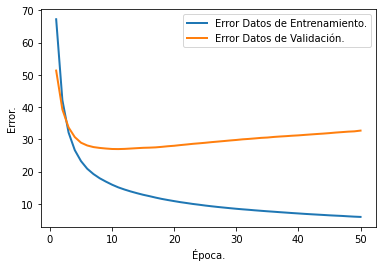

In [115]:
epocas = range(1, len(error_red_MS)+1)
plt.plot(epocas, error_red_MS, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, error_validacion_MS, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [116]:
vp_MS = predicciones(pesos_entrenados_MS, imagenes_entrenamiento[:1500])
print(vp_MS.shape,'\n')

precision_MS = ((etiquetas_entrenamiento[:1500] == vp_MS).sum()/len(etiquetas_entrenamiento[:1500]))*100
print(f"La precisión sobre los {imagenes_entrenamiento[:1500].shape[0]} datos de entrenamiento es del {precision_MS}%")

(1500,) 

La precisión sobre los 1500 datos de entrenamiento es del 98.6%


In [117]:
vp_MS_T = predicciones(pesos_entrenados_MS, imagenes_testeo[:])
print(vp_MS_T.shape,'\n')

DI_MS_T = (etiquetas_testeo[:] == vp_MS_T).sum() # Datos Inferidos en el cojunto de testeo o prueba.

precision_MS_T = (DI_MS_T/len(etiquetas_testeo[:]))*100
print(f"La precisión sobre los {imagenes_testeo[:].shape[0]} datos de prueba es del {precision_MS_T}%")

(10000,) 

La precisión sobre los 10000 datos de prueba es del 85.64%


In [118]:
print(f"La cantidad de datos inferida por este modelo es: {DI_MS_T}")

La cantidad de datos inferida por este modelo es: 8564


**Graficamos los errores de validación de cada modelo:**

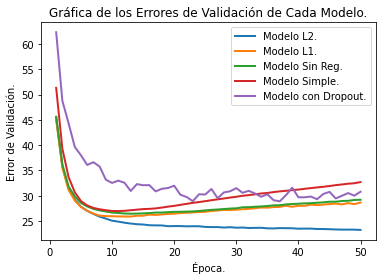

In [119]:
epocas = range(1, len(error_red_L2)+1)
plt.plot(epocas, error_validacion_L2, lw=2, label="Modelo L2.")
plt.plot(epocas, error_validacion_L1, lw=2, label="Modelo L1.")
plt.plot(epocas, error_validacion_SR, lw=2, label="Modelo Sin Reg.")
plt.plot(epocas, error_validacion_MS, lw=2, label="Modelo Simple.")
plt.plot(epocas, error_validacion_DPT, lw=2, label="Modelo con Dropout.")

#plt.axis([-1,50+1,1,4.6])
plt.title("Gráfica de los Errores de Validación de Cada Modelo.")
plt.xlabel("Época.")
plt.ylabel("Error de Validación.")
plt.legend()
plt.show()

**Observaciones:**  

El graficar los errores de validación de los distintos modelos *(siempre y cuando el conjunto de validación haya sido el mismo para todos los modelos)*, nos da una idea general de que modelo se desempeñará mejor.

**Graficamos la precisión de cada modelo en el conjunto de datos de testeo y agregamos el número de datos inferidos:**

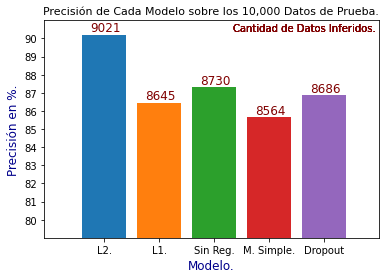

In [120]:
fig = plt.figure()

ax = fig.add_subplot(111)

modelos = list(range(1, 5+1))
precision_modelos = [precision_L2_T, precision_L1_T, precision_SR_T, precision_MS_T, precision_DPT_T]
aciertos_modelos = [DI_L2_T, DI_L1_T, DI_SR_T, DI_MS_T, DI_DPT_T]

for i,(precision,aciertos) in enumerate(zip(precision_modelos,aciertos_modelos)):
    ax.axis([-0.1,5+1,79,90+1])
    ax.bar(modelos[i],precision_modelos[i])
    ax.annotate(str(aciertos), xy=(modelos[i],precision_modelos[i]), xytext=(modelos[i]-0.25,precision_modelos[i]+0.2), 
                color="maroon", fontsize=12)
    ax.text(x = 3.35, y = 90.4, s = "Cantidad de Datos Inferidos.", color="maroon")
    ax.set_yticks(range(80,90+1))

ax.set_title("Precisión de Cada Modelo sobre los 10,000 Datos de Prueba.", fontsize=11)
ax.set_xlabel("Modelo.", fontsize=12, color="darkblue")
ax.set_ylabel("Precisión en %.", fontsize=12, color="darkblue")

plt.xticks(modelos,["L2.", "L1.", "Sin Reg.", "M. Simple.", "Dropout"])
plt.show()

**Observaciones:**  

Se aprecia claramente que el modelo que mejor desempeño tuvo sobre los datos de testeo, fue el modelo al cual se la aplicó la regularización **L2**, y el segundo modelo que mejor desempeño tuvo fue al que no se le aplicó ninguna regularización. Es importante comentar que nuestros modelos fueron entrenados haciendo uso de las primeras 1,500 muestras en el conjunto de entrenamiento.

Una vez más comprobamos que cuando carecemos de muestras de entrenamiento lo mejor es aplicar algún tipo de regularización a nuestros modelos.

***

**Ahora agregaremos 60 neuronas a la capa oculta para que sean 100, y observaremos como se desempeñan los dos tipos de regularización principales, Dropout y L2 directamente sobre los datos de testeo:**

In [121]:
# Nueva arquitectura:

np.random.seed(1)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 50, 100, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

Modelo sin regularización cuya capa oculta cuenta con 100 neuronas:

In [122]:
ps_1, er_1, ev_1 = algoritmo_aprendizaje(imagenes_entrenamiento[:1500], etiquetas_entrenamiento_ONE_HOT[:1500], 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones)


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 0



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 54.0874750178%
Aciertos sobre Datos de Entrenamiento: 1085.0

Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 31.79061284%
Aciertos sobre Datos de Entrenamiento: 1307.0

Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 24.5151489258%
Aciertos sobre Datos de Entrenamiento: 1377.0

Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 20.5998654716%
Aciertos sobre Datos de Entrenamiento: 1404.0

Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 17.9792074587%
Aciertos sobre Datos de Entrenamiento: 1423.0

Época: 6
Error Total de la Red sobre los Datos de Entrenamiento: 16.0435847778%
Aciertos sobre Datos de Entrenamiento: 1449.0

Época: 7
Error Total de la Red sobre los Datos de Entrenamiento: 14.4839821584%
Aciertos sobre Datos de Entrenamiento: 1460.0

Época: 8
Error Total de la Red sobre los Datos de Entrenamiento: 13.2046859566%
Aciertos sobre Datos de Entrenam

Modelo con regularización **dropout** cuya capa oculta cuenta con 100 neuronas:

In [123]:
ps_2, er_2, ev_2 = algoritmo_aprendizaje(imagenes_entrenamiento[:1500], etiquetas_entrenamiento_ONE_HOT[:1500], 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones)


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 3
¿Qué porcentaje de DROPOUT deseas? 0 < dp < 1
 0.5



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 74.5546418982%
Aciertos sobre Datos de Entrenamiento: 780.0

Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 54.5278468325%
Aciertos sobre Datos de Entrenamiento: 1020.0

Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 46.9199312216%
Aciertos sobre Datos de Entrenamiento: 1119.0

Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 43.2384002577%
Aciertos sobre Datos de Entrenamiento: 1182.0

Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 40.5422198791%
Aciertos sobre Datos de Entrenamiento: 1200.0

Época: 6
Error Total de la Red sobre los Datos de Entrenamiento: 38.7716696183%
Aciertos sobre Datos de Entrenamiento: 1217.0

Época: 7
Error Total de la Red sobre los Datos de Entrenamiento: 36.1513123421%
Aciertos sobre Datos de Entrenamiento: 1270.0

Época: 8
Error Total de la Red sobre los Datos de Entrenamiento: 34.710878089%
Aciertos sobre Datos de Entrenam

Modelo con regularización **L2** cuya capa oculta cuenta con 100 neuronas (Para este caso lambda = 0.004):

In [124]:
ps_3, er_3, ev_3 = algoritmo_aprendizaje(imagenes_entrenamiento[:1500], etiquetas_entrenamiento_ONE_HOT[:1500], 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones)


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 1
Inserta el porcentaje deseado para esta regularización: lambda[0,infinito)
 0.004



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 151.3393431807%
Aciertos sobre Datos de Entrenamiento: 1083.0

Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 114.0290134601%
Aciertos sobre Datos de Entrenamiento: 1307.0

Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 94.1707535168%
Aciertos sobre Datos de Entrenamiento: 1368.0

Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 79.7992936899%
Aciertos sobre Datos de Entrenamiento: 1388.0

Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 68.5110498779%
Aciertos sobre Datos de Entrenamiento: 1407.0

Época: 6
Error Total de la Red sobre los Datos de Entrenamiento: 59.3819770634%
Aciertos sobre Datos de Entrenamiento: 1418.0

Época: 7
Error Total de la Red sobre los Datos de Entrenamiento: 51.9368399385%
Aciertos sobre Datos de Entrenamiento: 1434.0

Época: 8
Error Total de la Red sobre los Datos de Entrenamiento: 45.8028444395%
Aciertos sobre Datos de Entr

In [125]:
print(f"La cantidad de aciertos del Modelo sin Regularización en el conjunto de testeo es: \
{(predicciones(ps_1,imagenes_testeo[:]) == etiquetas_testeo).sum()}")

print(f"La cantidad de aciertos del Modelo con Regularización DROPOUT en el conjunto de testeo es: \
{(predicciones(ps_2,imagenes_testeo[:]) == etiquetas_testeo).sum()}")

print(f"La cantidad de aciertos del Modelo con Regularización L2 en el conjunto de testeo es: \
{(predicciones(ps_3,imagenes_testeo[:]) == etiquetas_testeo).sum()}")

La cantidad de aciertos del Modelo sin Regularización en el conjunto de testeo es: 8939
La cantidad de aciertos del Modelo con Regularización DROPOUT en el conjunto de testeo es: 8998
La cantidad de aciertos del Modelo con Regularización L2 en el conjunto de testeo es: 9140


**Observaciones:**  

Cuando la cantidad de datos de entrenamiento y las neuronas en la(s) capa(s) oculta(s) en donde se aplicará **dropout** es amplia, el modelo regularizado con esta técnica se desempeñará mejor que el modelo sin regularización. Sin embargo, como se aprecia, la regularización **L2** sigue siendo superior. 

***

### Por último, entrenamos dos modelos sobre la arquitectura original con 50,000 datos de entrenamiento y 10,000 de validación:

In [126]:
np.random.seed(10)
alfa, iteraciones, neuronas_capa_oculta, pixeles_por_imagen, numero_de_clases = (0.005, 50, 40, 784, 10)

pesos_0_1 = 0.2*np.random.random((pixeles_por_imagen, neuronas_capa_oculta)) - 0.1 # Pesos entre capas 0 y 1.
pesos_1_2 = 0.2*np.random.random((neuronas_capa_oculta, numero_de_clases)) - 0.1 # Pesos entre capas 1 y 2.

**L2:**

In [127]:
ps_L2, er_L2, ev_L2 = algoritmo_aprendizaje(imagenes_entrenamiento[:50000], etiquetas_entrenamiento_ONE_HOT[:50000], 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [imagenes_entrenamiento[50000:], etiquetas_entrenamiento_ONE_HOT[50000:]])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 1
Inserta el porcentaje deseado para esta regularización: lambda[0,infinito)
 0.004



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 32.8524735389%
Aciertos sobre Datos de Entrenamiento: 45158.0
Error de Validación: 18.4265867157%
Aciertos sobre los Datos de Validación: 9308


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 22.3378609246%
Aciertos sobre Datos de Entrenamiento: 46393.0
Error de Validación: 17.6265795252%
Aciertos sobre los Datos de Validación: 9358


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 21.9194446734%
Aciertos sobre Datos de Entrenamiento: 46531.0
Error de Validación: 17.42925422%
Aciertos sobre los Datos de Validación: 9369


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 21.7815391828%
Aciertos sobre Datos de Entrenamiento: 46588.0
Error de Validación: 17.3922661626%
Aciertos sobre los Datos de Validación: 9370


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 21.7342315138%
Aciertos sobre Datos de Entrenamiento: 46617.0
Error de Validación: 17.4594139864

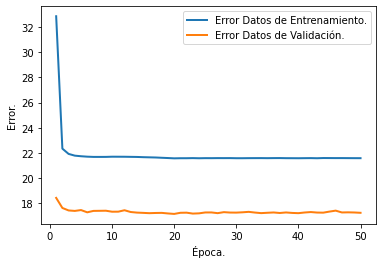

In [128]:
epocas = range(1, len(er_L2)+1)
plt.plot(epocas, er_L2, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, ev_L2, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [129]:
# L2
vp_ps_L2 = predicciones(ps_L2, imagenes_testeo[:])
print(vp_ps_L2.shape,'\n')

aciertos_L2 = (etiquetas_testeo[:] == vp_ps_L2).sum() # Datos Inferidos en el cojunto de testeo o prueba.

print(f"La cantidad de datos inferida por este modelo es: {aciertos_L2}")

(10000,) 

La cantidad de datos inferida por este modelo es: 9337


**Sin Regularización:**

In [131]:
ps_SR, er_SR, ev_SR = algoritmo_aprendizaje(imagenes_entrenamiento[:50000], etiquetas_entrenamiento_ONE_HOT[:50000], 
                                                                      [pesos_0_1, pesos_1_2], alfa, iteraciones,
                                                                      [imagenes_entrenamiento[50000:], etiquetas_entrenamiento_ONE_HOT[50000:]])


Hola ¿Cuál es el error que mínimo que deseas para la red neuronal?:  0
¿Qué tipo de regularización deseas?: Ninguno (0) / L2 (1) / L1 (2) / Dropout (3) / Descenso_Lote (4):
 0



Época: 1
Error Total de la Red sobre los Datos de Entrenamiento: 21.615696339%
Aciertos sobre Datos de Entrenamiento: 45469.0
Error de Validación: 16.4278260993%
Aciertos sobre los Datos de Validación: 9456


Época: 2
Error Total de la Red sobre los Datos de Entrenamiento: 15.1979961066%
Aciertos sobre Datos de Entrenamiento: 47253.0
Error de Validación: 14.815028002%
Aciertos sobre los Datos de Validación: 9510


Época: 3
Error Total de la Red sobre los Datos de Entrenamiento: 13.8996405435%
Aciertos sobre Datos de Entrenamiento: 47617.0
Error de Validación: 14.0185624056%
Aciertos sobre los Datos de Validación: 9549


Época: 4
Error Total de la Red sobre los Datos de Entrenamiento: 13.0817087399%
Aciertos sobre Datos de Entrenamiento: 47829.0
Error de Validación: 13.5800237192%
Aciertos sobre los Datos de Validación: 9551


Época: 5
Error Total de la Red sobre los Datos de Entrenamiento: 12.5573483545%
Aciertos sobre Datos de Entrenamiento: 47948.0
Error de Validación: 13.2861896696

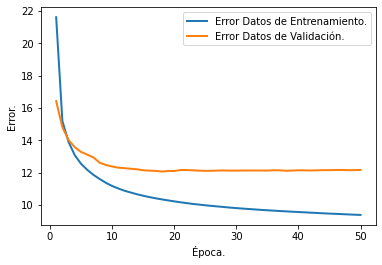

In [133]:
epocas = range(1, len(er_SR)+1)
plt.plot(epocas, er_SR, lw=2, label="Error Datos de Entrenamiento.")
plt.plot(epocas, ev_SR, lw=2, label="Error Datos de Validación.")
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()
plt.show()

In [134]:
vp_ps_SR = predicciones(ps_SR, imagenes_testeo[:])
print(vp_ps_L2.shape,'\n')

aciertos_SR = (etiquetas_testeo[:] == vp_ps_SR).sum() # Datos Inferidos en el cojunto de testeo o prueba.

print(f"La cantidad de datos inferida por este modelo es: {aciertos_SR}")

(10000,) 

La cantidad de datos inferida por este modelo es: 9596


In [135]:
print(f"La diferencia de aciertos en el conjunto de testeo es: {abs(aciertos_L2 - aciertos_SR)}")

La diferencia de aciertos en el conjunto de testeo es: 259


**Observaciones:**

Nuestro modelo **sin regularización**, **pero entrenado haciendo uso de 50,000 muestras**, infirió **259** datos más que el modelo con la regularización **L2**.

***

**CONCLUSIÓN GENERAL:**

<font color="red">Cuando el conjunto de datos de entrenamiento es muy basto, no es necesaria la regularización ya que esta podría perjudicar ligeramente el desempeño de nuestro modelo. En cualquier caso se puede experimentar con algún tipo de regularización, de preferencia **L2**, **Dropout** y por último **L1**. Lo anterior, con la finalidad de observar si existe alguna mejora en el desempeño de nuestro modelo sobre los datos.</font>